In [8]:
%matplotlib inline
from biocrnpyler import *
import numpy as np
import pylab as plt

timepoints = np.arange(0, 100, .1)

## Model 1: Simple Transcription and Translation
$G \rightarrow G + T$

$T \rightarrow T + X$

Species (3) = {0. dna[G] init_conc = 10, 1. rna[T] init_conc = 0, 2. protein[X] init_conc = 0}

Reactions (2) = [
0. dna[G] --> dna[G]+rna[T]
 Kf=k_forward * dna_G
  k_forward=0.2221875

1. rna[T] --> rna[T]+protein[X]
 Kf=k_forward * rna_T
  k_forward=0.075

]


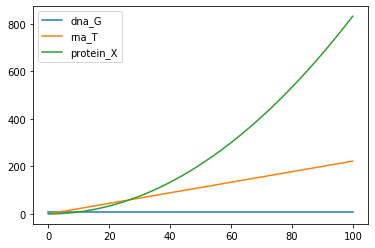

In [9]:
%matplotlib inline
#Create Mechanisms
mech_tx = SimpleTranscription()
mech_tl = SimpleTranslation()

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt")
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)

#Create DNAassembly
G = DNAassembly("G", rbs = "medium", promoter = "medium", transcript = "T", protein = "X", initial_conc = 10)
M.add_component(G)

#Compile the CRN
CRN = M.compile_crn()
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model1.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

## Model 2: Simple Transcription and Translation with Multiple Occupancy

$G \rightarrow G + T$

$T:Ribo^{closed}_{n-1} + Ribo \leftarrow \rightarrow T:Ribo^{open}_{n} \leftarrow \rightarrow T:Ribo^{closed}_{n} \rightarrow T + n Ribo + n X$

$T + Ribo \leftarrow \rightarrow T:Ribo^{open}_{1}$

Species (10) = {0. dna[G] init_conc = 10, 1. rna[T] init_conc = 0, 2. complex[protein[Ribo]:rna[T](open)] init_conc = 0, 3. complex[2x_protein[Ribo]:rna[T](open)] init_conc = 0, 4. complex[3x_protein[Ribo]:rna[T](open)] init_conc = 0, 5. complex[protein[Ribo]:rna[T](closed)] init_conc = 0, 6. complex[2x_protein[Ribo]:rna[T](closed)] init_conc = 0, 7. complex[3x_protein[Ribo]:rna[T](closed)] init_conc = 0, 8. protein[Ribo] init_conc = 150.0, 9. protein[X] init_conc = 0}

Reactions (12) = [
0. dna[G] --> dna[G]+rna[T]
 Kf=k_forward * dna_G
  k_forward=0.2221875

1. rna[T]+protein[Ribo] <--> complex[protein[Ribo]:rna[T](closed)]
 Kf=k_forward * rna_T * protein_Ribo
 Kr=k_reverse * complex_protein_Ribo_rna_T_closed_
  k_forward=100.0
  k_reverse=10.0

2. complex[protein[Ribo]:rna[T](closed)] --> complex[protein[Ribo]:rna[T](open)]
 Kf=k_forward * complex_protein_Ribo_rna_T_closed_
  k_forward=10.0

3. complex[2x_protein[Ribo]:rna[T](closed)] --> complex[2x_protein[Ribo]:rna[T](open)]
 Kf=k

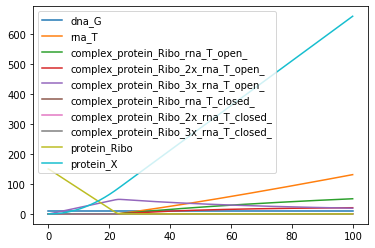

In [23]:
%matplotlib inline
#Create Mechanisms
mech_tx = SimpleTranscription()
ribo = Species("Ribo", material_type = "protein")
mech_tl = multi_tl(ribosome = ribo)

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt", parameters = {"max_occ":3})
M.add_mechanism(mech_tx)
M.add_mechanism(mech_tl)

#Create DNAassembly
G = DNAassembly("G", rbs = "medium", promoter = "medium", transcript = "T", protein = "X", initial_conc = 10)
M.add_component(G)
CRN = M.compile_crn()

#Create
print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model2.xml", for_bioscrape = True)
                
#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

## Model 3: RNA Degredation with Binding

$T + RNAase \leftarrow \rightarrow T:RNAase \rightarrow RNAase$

Species (3) = {0. rna[T] init_conc = 10, 1. protein[RNAase] init_conc = 45.0, 2. complex[protein[RNAase]:rna[T]] init_conc = 0}

Reactions (2) = [
0. rna[T]+protein[RNAase] <--> complex[protein[RNAase]:rna[T]]
 Kf=k_forward * rna_T * protein_RNAase
 Kr=k_reverse * complex_protein_RNAase_rna_T_
  k_forward=100.0
  k_reverse=10.0

1. complex[protein[RNAase]:rna[T]] --> protein[RNAase]
 Kf=k_forward * complex_protein_RNAase_rna_T_
  k_forward=0.001

]


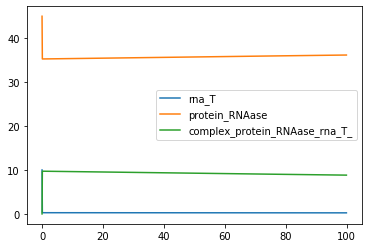

In [11]:
%matplotlib inline
#Create Mechanisms
rna = Species("T", material_type = "rna")
rnaase = Species("RNAase", material_type = "protein")
mech_deg = Degredation_mRNA_MM(rnaase)

#Create Mixture
M = Mixture(name = "e coli", parameter_file = "default_parameters.txt", parameters = {str(rna):10})
M.add_mechanism(mech_deg)
M.add_species(rna)

CRN = M.compile_crn()

print(CRN.pretty_print(show_keys = False))
CRN.write_sbml_file("model3.xml", for_bioscrape = True)

#Simulate with Bioscrape (slow)
R = CRN.simulate_with_bioscrape_via_sbml(timepoints)

#Plot all species
for s in CRN.species:
    plt.plot(timepoints, R[str(s)], label = str(s))

plt.legend()
plt.show()

# Interface Combinations
- Connecting two instances of (1) (independent genes) requires no mappings
- Connecting two instances of (2) (genes which share ribosomes) a requires 1 to 1 mapping
- Connecting (1) and (3) requires a 2 (bound and free transcript) to 1 (rna) mapping
- Connecting (2) and (3) requires a many (all transcript ribosome occupancies) to 1 mapping (rna) mapping
- Connectin multiple instances of (2) and (3) requires many instance x many species to 1 mapping

We can create also compile all these combinations using BioCRNpyler to get output that we can compare to Vivarium.

# Faster Simulation of Models with Bioscrape

starting simulation
{'dna_G': 0, 'rna_T': 1, 'protein_X': 2}
starting simulation
{'dna_G': 0, 'rna_T': 1, 'complex_protein_Ribo_rna_T_open_': 2, 'complex_protein_Ribo_2x_rna_T_open_': 3, 'complex_protein_Ribo_3x_rna_T_open_': 4, 'complex_protein_Ribo_rna_T_closed_': 5, 'complex_protein_Ribo_2x_rna_T_closed_': 6, 'complex_protein_Ribo_3x_rna_T_closed_': 7, 'protein_Ribo': 8, 'protein_X': 9}
starting simulation
{'rna_T': 0, 'protein_RNAase': 1, 'complex_protein_RNAase_rna_T_': 2}


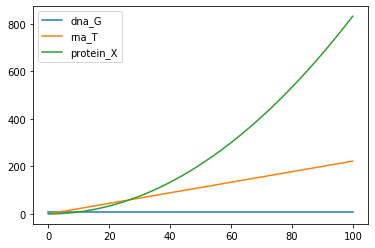

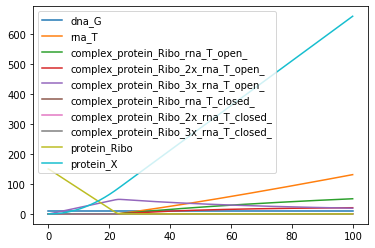

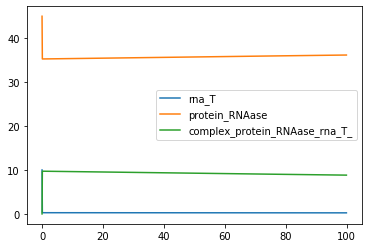

In [21]:
%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import DeterministicSimulator, ModelCSimInterface

for filename in ["model1.xml", "model2.xml", "model3.xml"]:
    #The following code happens automatically above, but should only be done once in a simulation loop
    #Load SBML Model
    model = Model(sbml_filename = filename, sbml_warnings = False)
    #Create an Interface Model --> Cython
    interface = ModelCSimInterface(model)
    interface.py_prep_deterministic_simulation()
    #Create a Simulator
    simulator = DeterministicSimulator()
    
    #How to change the initial conditions
    initial_condition_dict = None
    if initial_condition_dict is not None:
        model.set_species(initial_condition_dict)
        
    #How to get parameters:
    #model.get_params2index() #Returns a dictionary param_name --> index
    #model.get_param_list() #gets a list of parameters
    
    #How to set parameters
    #model.set_params(dict) #param_name --> new value
    
    print("starting simulation")
    output = simulator.py_simulate(interface, timepoints)
    
    print(model.get_species2index())
    plt.figure()
    for s in model.get_species2index():
        plt.plot(timepoints, output.py_get_result()[:, model.get_species2index()[s]], label = str(s))
    
    plt.legend()